In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Load Utils

In [2]:
def get_dataframe(scenario, dataframe, root_folder = ".." ,format = "pandas", **kwargs):
    """
    função que carrega o dataframe a partir do nome
    """
    path = list(Path(rf"{root_folder}/data/raw/scenario0{scenario}").rglob(rf"*{dataframe}.csv"))
    if format == "pandas":
        return pd.read_csv(path[0], **kwargs)
    elif format == "dask":
        return dd.read_csv(path, **kwargs)
    else:
        raise ValueError(f"format should be one of ['pandas', 'dask'], got {format}")

# Preprocessing

In [3]:
def filter_conditions(conditions):
    #filter only real conditions instead of findings
    msk  = ~conditions["DESCRIPTION"].str.contains("finding")
    return conditions[msk]

def cast_types_patients(patients):
    mapper = {
        "Id":str,
        "BIRTHDATE":str,
        "DEATHDATE":str,
        "MARITAL":str,
        "RACE":str,
        "ETHNICITY":str,
        "GENDER":str,
        "LAT":float,
        "LON":float
    }
    patients = patients.astype(mapper)
    patients["BIRTHDATE"] = pd.to_datetime(patients["BIRTHDATE"], format = "%Y-%m-%d")
    patients["DEATHDATE"] = pd.to_datetime(patients["DEATHDATE"], format = "%Y-%m-%d")
    return patients

def cast_types_conditions(conditions):
    mapper = {
        "START":str,
        "STOP":str,
        "PATIENT":str,
        "DESCRIPTION":str,
        "CODE":str,
    }
    conditions = conditions.astype(mapper)
    conditions["START"] = pd.to_datetime(conditions["START"], format = "%Y-%m-%d")
    conditions["STOP"] = pd.to_datetime(conditions["STOP"], format = "%Y-%m-%d")
    return conditions


def join_data(patients, conditions):
    joint = conditions.merge(
        patients,
        left_on = "PATIENT",
        right_on = "Id",
        how = "left"
    )
    return joint.drop(columns = ["Id"])



# Feature Engineering

In [4]:
def calculate_joint_features(joint_data):
    joint_data["STILL_HAS_CONDITION"] = joint_data["STOP"].isna().astype(int)    
    joint_data["DURATION"] = (joint_data["STOP"].fillna(pd.to_datetime("today")) - joint_data["START"])//pd.Timedelta(1,"d")
    joint_data["IS_DEAD"] = joint_data["DEATHDATE"].notna().astype(int)
    joint_data["SURVIVAL_SINCE_CONDITION"] = (joint_data["DEATHDATE"].fillna(pd.to_datetime("today")) - joint_data["START"])//pd.Timedelta(1,"d")
    joint_data["DIED_WITH_CONDITION"] = joint_data["IS_DEAD"]*joint_data["STILL_HAS_CONDITION"]
    duration_msk = joint_data["SURVIVAL_SINCE_CONDITION"] < joint_data["DURATION"]
    joint_data.loc[duration_msk, "DURATION"] = joint_data["SURVIVAL_SINCE_CONDITION"][duration_msk]
    joint_data["AGE"] = (joint_data["START"] - joint_data["BIRTHDATE"])/pd.Timedelta(365,"d")
    return joint_data

def build_lag_features(joint_data):
    joint_data = joint_data.set_index("START")
    
    list_mapper = {
        "STOP":list,
        "DESCRIPTION":list,
        "STILL_HAS_CONDITION":list,
        "DURATION":list,
        "SURVIVAL_SINCE_CONDITION":list,
        "CODE":list,
    }
    
    first_mapper = {
        "AGE":"first",
        "IS_DEAD":"first",
        "BIRTHDATE":"first",
        "DEATHDATE":"first",
        "MARITAL":"first",
        "RACE":"first",
        "ETHNICITY":"first",
        "GENDER":"first",
        "LAT":"first",
        "LON":"first"
    }
    
    historical_data = joint_data.groupby(["START","PATIENT"]).agg(
        {
            **list_mapper,
            **first_mapper
        }
    )
    
    
    for col in ["DESCRIPTION"]:
        historical_data[col] = historical_data[col].str.join("__SEP__")
    
    return historical_data.reset_index()

In [5]:
#joint_data = build_lag_features(joint_data)

In [6]:
#from tqdm import tqdm
#tqdm.pandas()

def _get_index_rolling_windows(rolling_obj):
    '''
    get positional indexes of rows of each rolling window
    '''    
    
    if hasattr(rolling_obj, '_selection'):        
        previous_selection = getattr(rolling_obj, '_selection')
    else:
        previous_selection = None
    
    INDEX_LIST = []
    #define function to append values to global INDEX_LIST since rolling apply won't let return arrays
    def f(x): INDEX_LIST.append(x.astype(int).values); return 0    
    assert '__indexer__' not in rolling_obj.obj.columns, 'DataFrame should not contain any col with "__indexer__" name'
    rolling_obj.obj = rolling_obj.obj.assign(__indexer__ = np.arange(len(rolling_obj.obj)), inplace = True)
    rolling_obj._selection = '__indexer__'
    rolling_obj.apply(f)#, raw = True)
    rolling_obj.obj = rolling_obj.obj.drop(columns = ['__indexer__'])
    
    delattr(rolling_obj, '_selection')
    
    if not previous_selection is None:
        setattr(rolling_obj, '_selection', previous_selection)
    
    
    return INDEX_LIST


def _apply_custom_rolling(rolling_obj, func, raw = True, engine = 'numpy', *args, **kwargs):
    
    engines = {
        'numpy':_rolling_apply_custom_agg_numpy,
    }
    _rolling_apply = engines[engine]
    
    indexes = _get_index_rolling_windows(rolling_obj)    
    if hasattr(rolling_obj, '_selection'):
        if getattr(rolling_obj, '_selection') is None:
            values = _rolling_apply(rolling_obj.obj, indexes, func, *args, **kwargs)    
        
        values = _rolling_apply(rolling_obj.obj[rolling_obj._selection], indexes, func, *args, **kwargs)
    else:
        values = _rolling_apply(rolling_obj.obj, indexes, func, *args, **kwargs)

    return values

    
def _rolling_apply_custom_agg_numpy(df, indexes, func, *args, **kwargs):
    '''
    applies some aggregation function over groups defined by index.
    groups are numpy arrays
    '''
    
    dfv = df.values    
    d = [[] for _ in range(len(indexes))]    
    for i in range(len(indexes)):
        data = dfv[indexes[i]]                
        if len(data) > 0:
            result = func(data, *args, **kwargs)        
            d[indexes[i][-1]] = result
    
    return d

In [7]:
from functools import reduce
def make_chronic_condition_history(arr):
    #check if condition still holds
    #print(arr)
    arr = arr[arr[:,1] == 1][:,0]

    if len(arr) > 0:
        return reduce(lambda x,y: x + "__SEP__" + y, arr)
    else:
        return ''
 
def make_recent_condition_history(arr):
    if len(arr) > 0:
        return reduce(lambda x,y: x + "__SEP__" + y, arr[:,0])
    else:
        return ''
    pass


In [456]:
def full_data_pipeline(scenario,root_folder = ".." ,format = "pandas"):
    
    condition_cols = ["START","STOP","PATIENT","DESCRIPTION","CODE"]
    patient_cols = ["Id", "BIRTHDATE", "DEATHDATE", "MARITAL", "RACE", "ETHNICITY", "GENDER", "LAT", "LON"]

    conditions = get_dataframe(scenario, root_folder=root_folder, dataframe = "conditions", usecols = condition_cols)
    patients = get_dataframe(scenario, root_folder=root_folder, dataframe = "patients", usecols = patient_cols)
    
    patients = cast_types_patients(patients)
    conditions = cast_types_conditions(conditions)
    conditions = filter_conditions(conditions)
    joint_data = join_data(patients, conditions)
    joint_data = calculate_joint_features(joint_data)
    joint_data = joint_data.sort_values(by = "START")

    condition_history = np.array(_apply_custom_rolling(joint_data.set_index("START").groupby("PATIENT").rolling("99999d")[["DESCRIPTION","STILL_HAS_CONDITION"]], make_chronic_condition_history))
    #recent_conditions = np.array(_apply_custom_rolling(joint_data.set_index("START").groupby("PATIENT").rolling("180d")[["DESCRIPTION"]], make_recent_condition_history))
    current_conditions = np.array(_apply_custom_rolling(joint_data.set_index("START").groupby("PATIENT").rolling("1d")[["DESCRIPTION"]], make_recent_condition_history))
    joint_data["CONDITION_HISTORY"] = condition_history
    #joint_data["RECENT_CONDITION"] = recent_conditions
    joint_data["CURRENT_CONDITION"] = current_conditions
    joint_data = joint_data.groupby(["START","PATIENT"]).last().reset_index()
    #DROP CASES WHEN NO CRONICAL DISEASE WAS DISCOVERED
    
    joint_data = joint_data.sort_values(by = "START").drop_duplicates(subset = ["CONDITION_HISTORY", "PATIENT"], keep = "first")
    record_weight = 1 / joint_data.groupby(["PATIENT"])["START"].transform(len)
    joint_data["RECORD_WEIGHT"] = record_weight
    return joint_data

In [457]:
TRAIN_SCENARIO = 1
TEST_SCENARIO = 2

scenario1 = full_data_pipeline(TRAIN_SCENARIO)
scenario2 = full_data_pipeline(TEST_SCENARIO)

In [458]:
#sanity_check
#full_data.set_index(["PATIENT","START"]).loc['7356b986-af5b-713b-cfe4-a5e5c2914190']

# Feature Extraction

In [460]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer
from sklearn.base import clone

In [461]:
def make_feature_extraction_pipeline(
    numerical_features,
    categorical_features,
    bag_features,
    targets = None,
    remove_colinearity = False
):
    
    numerical_pipeline = [("numerical_pipeline",QuantileTransformer(),numerical_features)]
    
    categorical_pipeline = [("categroical_pipeline", OneHotEncoder(handle_unknown="ignore"), categorical_features)]
    
    if not remove_colinearity:
        _bag_pipeline = CountVectorizer(tokenizer = lambda x: x.split("__SEP__"), min_df = 5, lowercase=False)
    
    else:
        _bag_pipeline = make_pipeline(
            CountVectorizer(tokenizer = lambda x: x.split("__SEP__"), min_df = 5, lowercase=False),
            TruncatedSVD(50)
        )

    bag_pipeline = [(f"bag_features_{i}", clone(_bag_pipeline), i) for i in bag_features]
    
    transformers = numerical_pipeline + categorical_pipeline + bag_pipeline
    
    full_pipeline = ColumnTransformer(
        transformers,
        n_jobs = -1,
        verbose = True
    )
    
    return full_pipeline

def get_transformed_features_names(full_pipeline, n_bag_features):
    num_features = np.array(full_pipeline.transformers[0][-1]).flatten()
    cat_features = np.array([full_pipeline.transformers_[1][1].feature_names_in_[i] + "__" + full_pipeline.transformers_[1][1].categories_[i] for i in range(len(full_pipeline.transformers_[1][1].feature_names_in_))]).flatten()
    cat_features = np.hstack(cat_features)
    all_bag_features = [np.array([full_pipeline.transformers_[2 + j][2] + "__" + list(full_pipeline.transformers_[2 + j][1].vocabulary_)[i] for i in range(len(full_pipeline.transformers_[2 + j][1].vocabulary_))]).flatten() for j in range(n_bag_features)]
    all_features = np.hstack([num_features, cat_features, *all_bag_features])
    return all_features

    

In [462]:
target_cols = ["IS_DEAD", "SURVIVAL_SINCE_CONDITION"]
numerical_features = ['LAT', 'LON', "AGE"]
bag_features = ["CONDITION_HISTORY", "CURRENT_CONDITION"]
categorical_features = ['RACE', 'ETHNICITY', 'GENDER']
weight_cols = ["RECORD_WEIGHT"]
extra_cols = ["PATIENT","START"]

feature_cols = numerical_features + categorical_features + bag_features

In [463]:
scenario1[extra_cols + feature_cols + target_cols].sort_values(by = ["PATIENT","START"]).set_index("PATIENT").loc["0359aba6-a9cb-91d2-4c61-f0804f669124"]

,START,LAT,LON,AGE,RACE,ETHNICITY,GENDER,CONDITION_HISTORY,CURRENT_CONDITION,IS_DEAD,SURVIVAL_SINCE_CONDITION
PATIENT,,,,,,,,,,,
0359aba6-a9cb-91d2-4c61-f0804f669124,1963-12-19,41.556932,-70.961523,31.000000,white,nonhispanic,M,Sleep disorder (disorder),Sleep disorder (disorder),0,21334
0359aba6-a9cb-91d2-4c61-f0804f669124,1964-01-04,41.556932,-70.961523,31.043836,white,nonhispanic,M,Sleep disorder (disorder)__SEP__Sleep apnea (d...,Sleep apnea (disorder),0,21318
0359aba6-a9cb-91d2-4c61-f0804f669124,1964-03-09,41.556932,-70.961523,31.221918,white,nonhispanic,M,Sleep disorder (disorder)__SEP__Sleep apnea (d...,Hypertension,0,21253
0359aba6-a9cb-91d2-4c61-f0804f669124,1970-04-13,41.556932,-70.961523,37.320548,white,nonhispanic,M,Sleep disorder (disorder)__SEP__Sleep apnea (d...,Coronary Heart Disease,0,19027
0359aba6-a9cb-91d2-4c61-f0804f669124,1994-08-10,41.556932,-70.961523,61.663014,white,nonhispanic,M,Sleep disorder (disorder)__SEP__Sleep apnea (d...,Chronic sinusitis (disorder),0,10142
0359aba6-a9cb-91d2-4c61-f0804f669124,2006-11-13,41.556932,-70.961523,73.931507,white,nonhispanic,M,Sleep disorder (disorder)__SEP__Sleep apnea (d...,History of myocardial infarction (situation)__...,0,5664


In [464]:
full_pipeline = make_feature_extraction_pipeline(numerical_features, categorical_features, bag_features)

In [465]:
full_pipeline.fit(scenario1)

ColumnTransformer(n_jobs=-1,
                  transformers=[('numerical_pipeline', QuantileTransformer(),
                                 ['LAT', 'LON', 'AGE']),
                                ('categroical_pipeline',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['RACE', 'ETHNICITY', 'GENDER']),
                                ('bag_features_CONDITION_HISTORY',
                                 CountVectorizer(lowercase=False, min_df=5,
                                                 tokenizer=<function make_feature_extraction_pipeline.<locals>.<lambda> at 0x1487dfd30>),
                                 'CONDITION_HISTORY'),
                                ('bag_features_CURRENT_CONDITION',
                                 CountVectorizer(lowercase=False, min_df=5,
                                                 tokenizer=<function make_feature_extraction_pipeline.<locals>.<lambda> at 0x1487dfd30>),
                                 'CURRENT_CONDITION')],
                  verbose=True)

In [466]:
list(full_pipeline.transformers_[-2][1].vocabulary_)[:10]

['Chronic sinusitis (disorder)',
 'Otitis media',
 'Appendicitis',
 'History of appendectomy',
 'Epilepsy',
 'History of single seizure (situation)',
 'Seizure disorder',
 'Acute myeloid leukemia  disease (disorder)',
 'Febrile neutropenia (disorder)',
 'Hypertension']

In [467]:
full_pipeline.transform(scenario2)

<3059x229 sparse matrix of type '<class 'numpy.float64'>'
	with 29189 stored elements in Compressed Sparse Row format>

# Modelling

In [483]:
# importing model and utils from xgbse
from sklearn.model_selection import train_test_split
from xgbse import XGBSEKaplanNeighbors
from xgbse.converters import convert_to_structured

full_pipeline = make_feature_extraction_pipeline(numerical_features, categorical_features, bag_features, remove_colinearity=False)

# splitting to X, y format
X_1 = full_pipeline.fit_transform(scenario1[feature_cols])
y_1 = convert_to_structured(scenario1["SURVIVAL_SINCE_CONDITION"], scenario1['IS_DEAD'])

X_2 = full_pipeline.transform(scenario2[feature_cols])
y_2 = convert_to_structured(scenario2["SURVIVAL_SINCE_CONDITION"], scenario2['IS_DEAD'])

In [567]:
TIME_BINS = [7,30,90,180,360,720, 1440, 2880, 5000, 10000, 36500]

# Feature Selection com p-valores de regressão cox

In [568]:
import warnings
warnings.filterwarnings("ignore")

In [569]:
transformed_feature_names = get_transformed_features_names(full_pipeline, 2)

In [570]:
from lifelines import CoxPHFitter
wbf = CoxPHFitter(penalizer=0.01).fit(
    pd.DataFrame(X_1.A).assign(
        w = scenario1["RECORD_WEIGHT"].values,
        T = scenario1["SURVIVAL_SINCE_CONDITION"].values,
        E = scenario1["IS_DEAD"].values
    )
    , "T", "E", weights_col='w', robust = True
)

In [571]:
cox_preds = wbf.predict_survival_function(X_2.A, times = np.array(TIME_BINS)).T

<AxesSubplot:xlabel='p', ylabel='Density'>

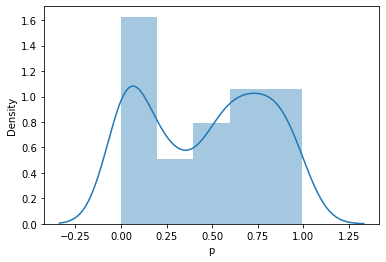

In [572]:
sns.distplot(wbf.summary["p"])

In [573]:
keep_feature_indexes = wbf.summary[wbf.summary["p"] < 1].index.values
keep_feature_pvalues = wbf.summary.loc[keep_feature_indexes]["p"].values
keep_feature_values = wbf.summary.loc[keep_feature_indexes]["coef"].values
keep_feature_names = transformed_feature_names[keep_feature_indexes]

p_argsort = np.argsort(keep_feature_pvalues)
value_argsort = np.argsort(abs(keep_feature_values))[-50:]

# Features do tipo CURRENT_CONDITION estão dando resultados um pouco estranhos, por isso, iremos retira-las da pipeline
Provavelmente, a descoberta da condição implica diminuir a chance de morte

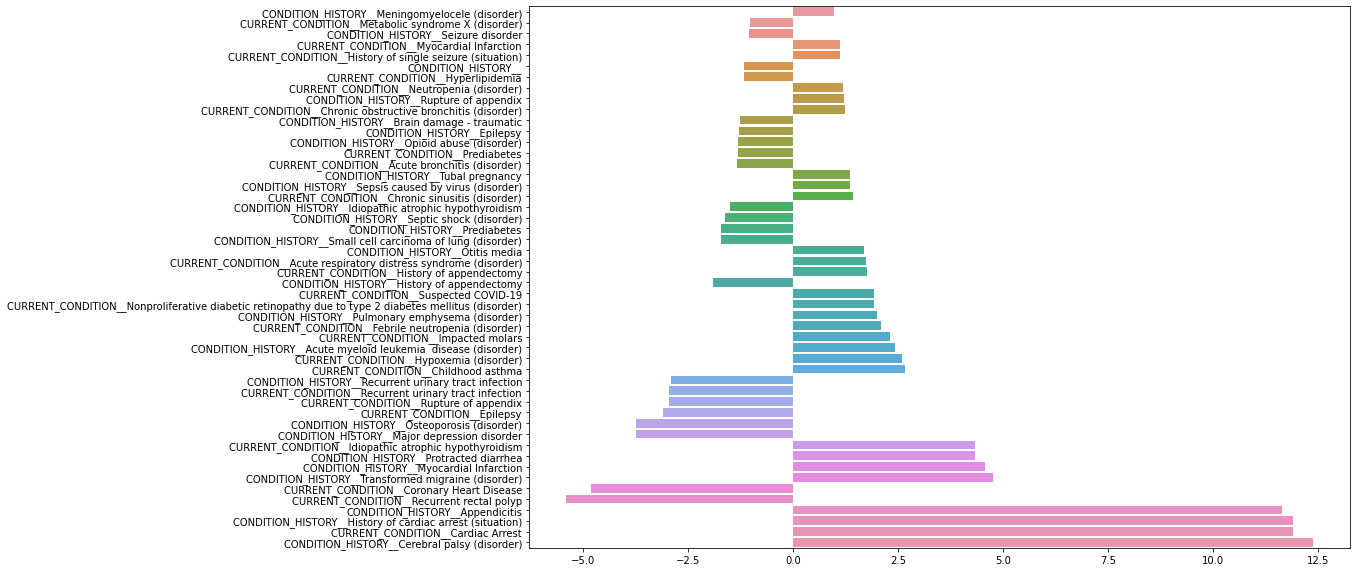

In [574]:
sns.barplot(x = keep_feature_values[value_argsort], y = keep_feature_names[value_argsort])
plt.subplots_adjust(-1,-1)

# Modelling with xgbse

In [575]:
target_cols = ["IS_DEAD", "SURVIVAL_SINCE_CONDITION"]
numerical_features = ['LAT', 'LON', "AGE"]
bag_features = ["CONDITION_HISTORY"] #removed current condition
categorical_features = ['RACE', 'ETHNICITY', 'GENDER']
weight_cols = ["RECORD_WEIGHT"]
extra_cols = ["PATIENT","START"]

feature_cols = numerical_features + categorical_features + bag_features

In [576]:
full_pipeline1 = make_feature_extraction_pipeline(numerical_features, categorical_features, bag_features, remove_colinearity=False)
full_pipeline2 = make_feature_extraction_pipeline(numerical_features, categorical_features, bag_features, remove_colinearity=False)
full_pipeline3 = make_feature_extraction_pipeline(numerical_features, categorical_features, bag_features, remove_colinearity=False)
# splitting to X, y format
#case 1
X_train_1 = full_pipeline1.fit_transform(scenario1[feature_cols])
y_train_1 = convert_to_structured(scenario1["SURVIVAL_SINCE_CONDITION"], scenario1['IS_DEAD'])

X_test_1 = full_pipeline1.transform(scenario2[feature_cols])
y_test_1 = convert_to_structured(scenario2["SURVIVAL_SINCE_CONDITION"], scenario2['IS_DEAD'])

#case 2
X_train_2 = full_pipeline2.fit_transform(scenario2[feature_cols])
y_train_2 = convert_to_structured(scenario2["SURVIVAL_SINCE_CONDITION"], scenario2['IS_DEAD'])

X_test_2 = full_pipeline2.transform(scenario1[feature_cols])
y_test_2 = convert_to_structured(scenario1["SURVIVAL_SINCE_CONDITION"], scenario1['IS_DEAD'])

#case 3
scenario1and2 = pd.concat([scenario1,scenario2], axis = 0).sort_values(by = "START")
#date split
scenario1and2_train,scenario1and2_test = train_test_split(scenario1and2, train_size=0.8, shuffle = False)

X_train_3 = full_pipeline3.fit_transform(scenario1and2_train[feature_cols])
y_train_3 = convert_to_structured(scenario1and2_train["SURVIVAL_SINCE_CONDITION"], scenario1and2_train['IS_DEAD'])

X_test_3 = full_pipeline3.transform(scenario1and2_test[feature_cols])
y_test_3 = convert_to_structured(scenario1and2_test["SURVIVAL_SINCE_CONDITION"], scenario1and2_test['IS_DEAD'])

In [577]:
# fitting xgbse model
xgbse_model1 = XGBSEKaplanNeighbors(n_neighbors=50)
xgbse_model2 = XGBSEKaplanNeighbors(n_neighbors=50)
xgbse_model3 = XGBSEKaplanNeighbors(n_neighbors=50)

xgbse_model1.fit(X_train_1, y_train_1, index_id = pd.Index(np.arange(X_train_1.shape[0])), time_bins = TIME_BINS)
xgbse_model2.fit(X_train_2, y_train_2, index_id = pd.Index(np.arange(X_train_2.shape[0])), time_bins = TIME_BINS)
xgbse_model3.fit(X_train_3, y_train_3, index_id = pd.Index(np.arange(X_train_3.shape[0])), time_bins = TIME_BINS)

XGBSEKaplanNeighbors(n_neighbors=50,
                     xgb_params={'aft_loss_distribution': 'normal',
                                 'aft_loss_distribution_scale': 1,
                                 'booster': 'dart', 'colsample_bynode': 0.5,
                                 'eval_metric': 'aft-nloglik',
                                 'learning_rate': 0.05, 'max_depth': 8,
                                 'min_child_weight': 50,
                                 'objective': 'survival:aft', 'subsample': 0.5,
                                 'tree_method': 'hist'})

In [578]:
# predicting
mean1, upper_ci1, lower_ci1 = xgbse_model1.predict(X_test_1, return_ci=True)
mean2, upper_ci2, lower_ci2 = xgbse_model2.predict(X_test_2, return_ci=True)
mean3, upper_ci3, lower_ci3 = xgbse_model3.predict(X_test_3, return_ci=True)

In [579]:
mean1.head()

,7,30,90,180,360,720,1440,2880,5000,10000,36500
0,0.96,0.94,0.92,0.900000,0.879070,0.879070,0.809460,0.780551,0.657306,0.657306,0.657306
1,0.94,0.92,0.90,0.900000,0.879545,0.859091,0.770350,0.722909,0.691478,0.691478,0.518608
2,0.92,0.90,0.88,0.860000,0.860000,0.860000,0.800000,0.737892,0.709511,0.709511,0.232808
3,0.94,0.92,0.90,0.880000,0.880000,0.880000,0.814994,0.814994,0.747078,0.747078,0.000000
4,0.94,0.94,0.94,0.919565,0.919565,0.919565,0.853271,0.853271,0.817718,0.817718,0.000000


# Modeling with Cox

In [580]:
wbf1 = CoxPHFitter(penalizer=0.01, l1_ratio = 0.01).fit(pd.DataFrame(X_train_1.A).assign(T = scenario1["SURVIVAL_SINCE_CONDITION"].values, E = scenario1["IS_DEAD"].values), "T", "E")
wbf2 = CoxPHFitter(penalizer=0.01, l1_ratio = 0.01).fit(pd.DataFrame(X_train_2.A).assign(T = scenario2["SURVIVAL_SINCE_CONDITION"].values, E = scenario2["IS_DEAD"].values), "T", "E")
wbf3 = CoxPHFitter(penalizer=0.01, l1_ratio = 0.01).fit(pd.DataFrame(X_train_3.A).assign(T = scenario1and2_train["SURVIVAL_SINCE_CONDITION"].values, E = scenario1and2_train["IS_DEAD"].values), "T", "E")

In [581]:
cox_preds1 = wbf1.predict_survival_function(X_test_1.A, times = np.array(TIME_BINS)).T
cox_preds2 = wbf2.predict_survival_function(X_test_2.A, times = np.array(TIME_BINS)).T
cox_preds3 = wbf3.predict_survival_function(X_test_3.A, times = np.array(TIME_BINS)).T

# Resultados

In [596]:
# predicting
def plot_ci(mean, upper_ci, lower_ci, label, i=42, title='Probabilidade de sobrevivência $P(T \geq t)$'):
    
    # plotting mean and confidence intervals
    f = plt.figure(figsize=(12, 4), dpi=120)
    plt.plot(mean.columns,mean.iloc[i])
    plt.fill_between(mean.columns, lower_ci.iloc[i], upper_ci.iloc[i], alpha=0.2)

    plt.title(title)
    plt.xlabel('Tempo [dias]')
    plt.ylabel('Probabilidade')
    plt.tight_layout()
    dead, time_since = label[i]
    time_since = int(time_since)
    text = "vivo" if not dead else "morto"
    color = "green" if not dead else "red"
    plt.axvline(min(time_since, mean.columns.max()), color = color,label = f"{text}, viveu {time_since} dias após encontro")
    plt.legend()
    return f
    

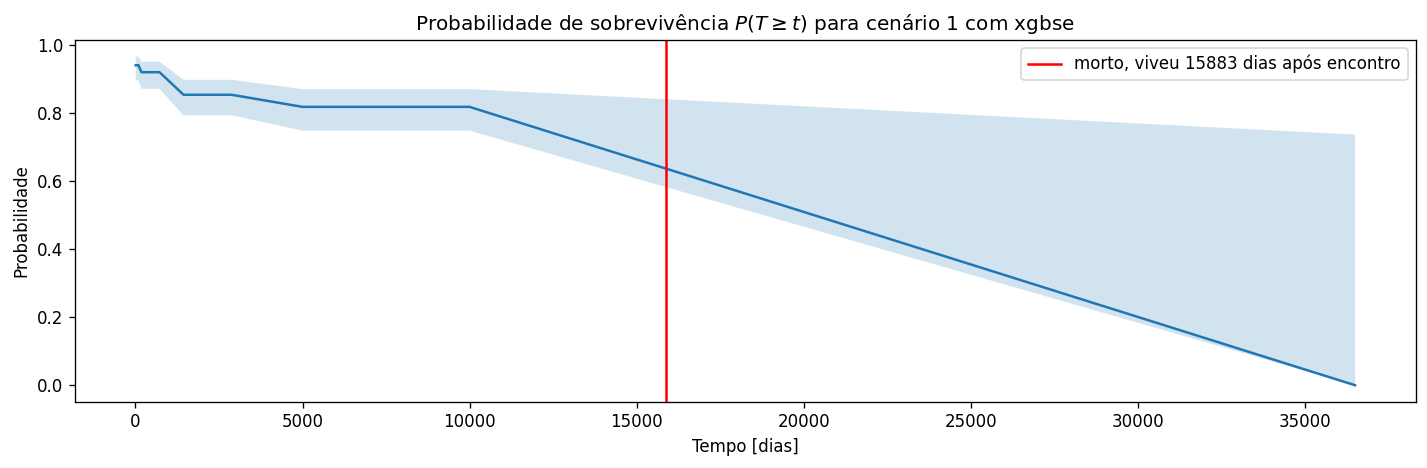

In [600]:
# plotting CIs
if not 'i' in globals():
    i = 0
else:
    pass#i +=1

f = plot_ci(mean1, upper_ci1, lower_ci1, y_test_1,i = i, title = 'Probabilidade de sobrevivência $P(T \geq t)$ para cenário 1 com xgbse')
f.savefig(rf"../files/survival_curve_1_{i}")

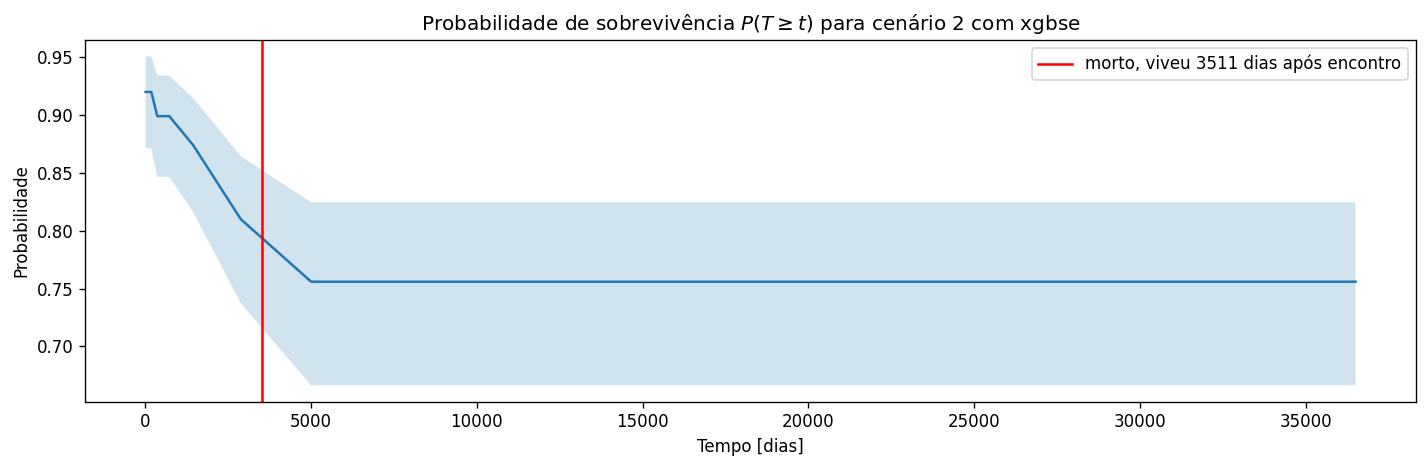

In [601]:
# plotting CIs
if not 'j' in globals():
    j = 0
else:
    pass
    #j +=1

f = plot_ci(mean2, upper_ci2, lower_ci2, y_test_2, i = j, title = 'Probabilidade de sobrevivência $P(T \geq t)$ para cenário 2 com xgbse')
f.savefig(rf"../files/survival_curve_2_{j}")

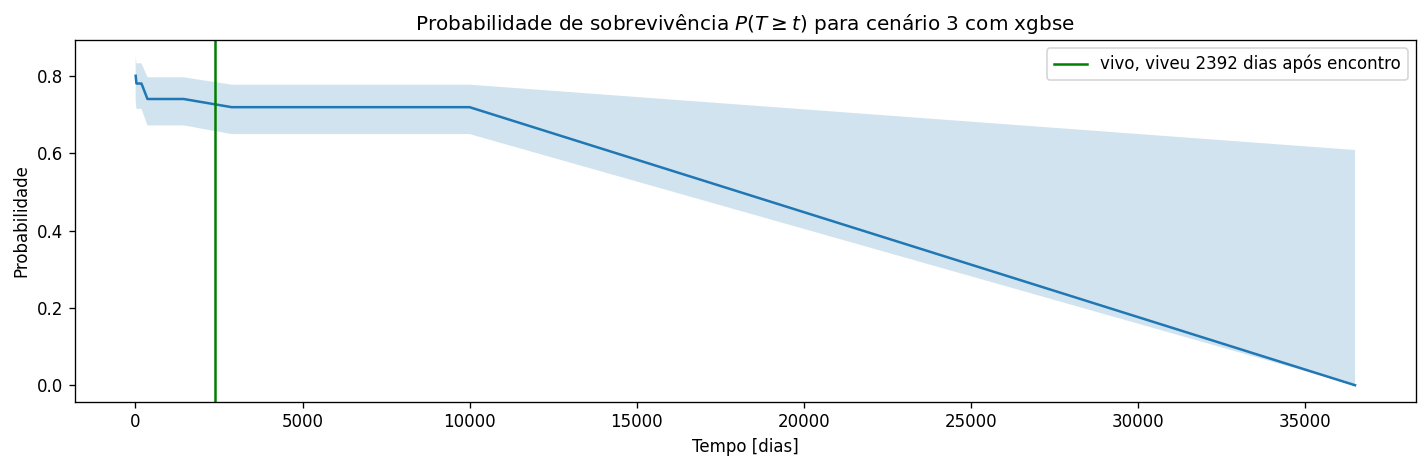

In [603]:
# plotting CIs
if not 'k' in globals():
    k = 0
else:
    pass
    #k +=1

f = plot_ci(mean3, upper_ci3, lower_ci3, y_test_3, i = k, title = 'Probabilidade de sobrevivência $P(T \geq t)$ para cenário 3 com xgbse')
f.savefig(rf"../files/survival_curve_3_{k}")

In [604]:
from xgbse.metrics import concordance_index, approx_brier_score

In [608]:
print(f"XGBSE-1 C-index: {round(concordance_index(y_test_1, mean1),3)}")
print(f"XGBSE-1 Avg. Brier Score: {round(approx_brier_score(y_test_1, mean1),3)}")

print(f"COX-1 C-index: {round(concordance_index(y_test_1, cox_preds1),3)}")
print(f"COX-1 Avg. Brier Score: {round(approx_brier_score(y_test_1, cox_preds1),3)}")
print()
print()
print(f"XGBSE-2 C-index: {round(concordance_index(y_test_2, mean2),3)}")
print(f"XGBSE-2 Avg. Brier Score: {round(approx_brier_score(y_test_2, mean2),3)}")

print(f"COX-2 C-index: {round(concordance_index(y_test_2, cox_preds2),3)}")
print(f"COX-2 Avg. Brier Score: {round(approx_brier_score(y_test_2, cox_preds2),3)}")
print()
print()
print(f"XGBSE-3 C-index: {round(concordance_index(y_test_3, mean3),3)}")
print(f"XGBSE-3 Avg. Brier Score: {round(approx_brier_score(y_test_3, mean3),3)}")

print(f"COX-3 C-index: {round(concordance_index(y_test_3, cox_preds3),3)}")
print(f"COX-3 Avg. Brier Score: {round(approx_brier_score(y_test_3, cox_preds3),3)}")

XGBSE-1 C-index: 0.716
XGBSE-1 Avg. Brier Score: 0.536
COX-1 C-index: 0.767
COX-1 Avg. Brier Score: 0.118


XGBSE-2 C-index: 0.691
XGBSE-2 Avg. Brier Score: 1.208
COX-2 C-index: 0.568
COX-2 Avg. Brier Score: 0.456


XGBSE-3 C-index: 0.785
XGBSE-3 Avg. Brier Score: 0.029
COX-3 C-index: 0.836
COX-3 Avg. Brier Score: 0.023


In [153]:
brier_scores = []
for i in range(len(y_test)):
    brier_scores.append(approx_brier_score(y_test[i:i+1], mean[i:i+1], aggregate = None))

In [154]:
brier_scores = np.array(brier_scores)

(39, 7)

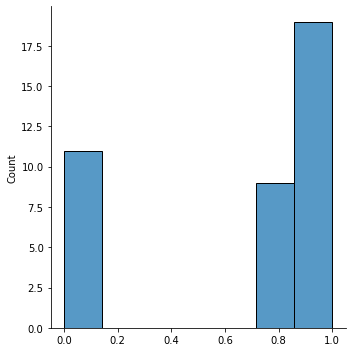

In [156]:
#sns.distplot(brier_scores[brier_scores.mean(0) > 0])
sns.displot(brier_scores[brier_scores.mean(1) > 0][:,1])


brier_scores[brier_scores.mean(1) > 0].shape